# Chainerハンズオン：画像セグメンテーション

[Open on Github](https://github.com/mitmul/chainer-handson/blob/master/segmentation-handson/Image_Segmentation_with_Chainer.ipynb)

画像を対象とした深層学習の応用技術には様々なものがあります．例えば，画像の中の個別の物体の周りを矩形で囲むようにして検出する**物体検出**や，画像内で個別物体が占める領域を認識する**画像セグメンテーション**などがあります．

**物体検出**は，対象物体の**「種類」と「位置」を認識する技術**であるといえます．

<center>
<br />
<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/FasterRCNN-result.png" width="400" /><br />
物体検出の例．矩形で対象物体を囲い，そのクラスを答えるタスク．
<br />
</center>

**画像セグメンテーション**には2種類あります．1つは，個別の物体を区別するInstance-aware Segmentationです．もう一つは，同一クラスの物体であれば個を区別しないSemantic Segmentationです．今回は，後者を扱います．

<center>
<br />
<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/PSPNet-result.png" width="500" /><br />
Semantic Segmentationの例．ピクセル単位でクラス分類を行うタスク．画像を，予め決められた数の色で塗り絵をするようなイメージ．
<br />
</center>

画像セグメンテーションは，画像全体に対して一つのクラスを割り当てる分類問題とは異なり，画像内の全ピクセルを，ピクセルごとに分類していきます．そのため，Pixel labeling タスクとも呼ばれます．これは，対象物体の**「種類」と「位置」と「形」を認識する技術**であるといえるでしょう．

今回は，深層学習フレームワークChainerを用いて，このSemantic Segmentationタスクに取り組んでみましょう．

# 環境

ここで用いるライブラリは，

- Chainer
- CuPy
- ChainerCV
- matplotlib

です．Google Colab上では，以下のようにしてインストールすることができます．以下のセルを実行してください．

In [0]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install chainer cupy-cuda80 chainercv matplotlib

インストールが完了したら，以下のセルを実行して，各ライブラリのバージョンなどを確認します．

In [0]:
import chainer
import cupy
import chainercv
import matplotlib

chainer.print_runtime_info()
print('ChainerCV:', chainercv.__version__)
print('matplotlib:', matplotlib.__version__)

Chainer: 4.4.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.4.1
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213
ChainerCV: 0.10.0
matplotlib: 2.1.2


<a id="index"></a>
# 目次

1. [Semantic Segmenationについて](#about_segmenation)
2. [使用するデータセット](#about_dataset)
3. [Chainerの概要](#about_chainer)
  1. [Chainerを用いた学習の流れ](#about_trainer)
4. [三層パーセプトロンによるセグメンテーション](#about_perceptron)
  1. [データセットの準備](#prepare_dataset)
  2. [モデルの定義](#define_model)
  3. [Trainerの定義](#define_trainer)
  4. [学習開始](#start_training)
  5. [評価](#evaluation)
5. [畳み込みネットワークを用いたセグメンテーション](#cnn_segmentation)
  1. [Convolutionレイヤ](#convolution_layer)
  2. [Deconvolutionレイヤ](#deconvolution_layer)
  3. [全畳込みネットワーク](#fcn)
  4. [Classifierクラスの改良](#new_classifier)
  5. [新しいモデルを使った学習](#new_training)
  6. [学習結果を見てみよう](#check_result)
6. [さらなる精度向上へのヒント](#go_further)
  1. [SegNet](#SegNet)
  2. [U-Net](#U-Net)
  3. [PSPNet](#PSPNet)
7. [その他の参考資料](#information)

<a id="about_segmentation"></a>
# 1. Semantic Segmentationについて

Semantic Segmentationは，Computer Visionの分野で現在も活発に研究が行われているタスクの一つで，入力画像の画素ひとつひとつに対して，なんらかのクラスを与えていくという問題です．しかし，**人間でもあるピクセルひとつだけを見てそれが何かを推測するのは不可能です**．そのため，いかにして周囲のピクセルの情報を加味しながら，ひとつひとつのピクセルの分類を行うか，が重要となります．

ニューラルネットワークを用いてこの問題を解く場合は，**「画像を入力して，画像を出力するネットワーク」**を作って学習することになります．そのため，入力画像とペアになる正解ラベル画像は，同じ大きさを持つ，各ピクセルの所属クラス番号が入ったシングルチャンネルの画像とすることが一般的です．

ネットワークの出力は，$C$クラス分類をする場合は$C$チャンネルの画像になります．それを各ピクセルごとにチャンネル方向にSoftmaxを取って確率ベクトルにし，正解のクラスの値が大きくなるよう（高い確信をもって正解クラスを予測できるよう）学習を進めます．画像分類（Classification）の際のロス計算を，**ピクセルごとに行っている**と考えると分かりやすいかと思います．ピクセルごとの分類誤差を，画像サイズ分だけ足し合わせたものがSemantic Segmentationタスクにおいて最小化したいロス関数となります．

ここで，$C=2$の場合だけは，ネットワークの出力を$C-1 = 1$チャネル画像にし，ロス関数をSigmoid Cross Entropyとします．$C \geq 2$の場合は，ネットワークの出力を$C$チャンネル画像にし，チャンネル方向にSoftmaxを取った上で正解ラベル画像とのCross entropyを計算するSoftmax Cross Entropyをロス関数とします．2クラスの場合に出力の1チャネル画像を閾値 $0.5$ で二値化し，予測ラベル画像として出力するのは，$C \geq 2$クラスの場合において$C$個のクラスそれぞれに確率が与えられたあとそれが最大になるチャンネル番号を予測クラスとして出力するのと同じことです．

[▲ Go to index](#index)

<a id="about_dataset"></a>
# 2. 使用するデータセット

これから使用するデータセットは，心臓MRI画像（短軸像）と，それに専門家がラベルを付けたものです．データについて詳しくはこちらをご参照ください[[1](#1), [2](#2), [3](#3)]．

下記にこのデータセットから抜き出した画像ペアの例を示します．下のセルを実行してみてください．

In [0]:
!curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip
!unzip train.zip && rm -rf train.zip
!curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip
!unzip val.zip && rm -rf val.zip

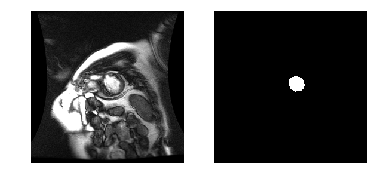

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/000.png'))
label = np.asarray(Image.open('train/label/000.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

左側がMRI画像，右側がそれに対し専門家が作成した左心室の部分のマスク画像となっています．右側のマスク画像のうち，**白く塗りつぶされている領域が，今回見つけ出したい左心室の領域となっています**．左心室の大きさは，画像ごとに異なっており，形もまた様々です．ただし，**画像全体に対して左心室が占める領域は比較的小さい**ということは共通しています．

今回は，MRI画像データを，提供元が配布している形式（DICOM形式）から扱いやすいよう一般的な画像フォーマット（PNG）に変換して用いますが，そのための作業については説明しません．こういったデータの整形や前処理が，機械学習においては非常に重要となることがあるのは確かですが，今回はその部分に関する解説はスコープを大きくはずれるため，割愛します．（もし今回用いるMRI画像群のデータ整形の方法について興味をお持ちの方は，以前行われたKaggleのコンペティションに関連して提供されているこちらのチュートリアルをご参照ください：[Kaggle competition: Second Annual Data Science Bowl](https://www.kaggle.com/c/second-annual-data-science-bowl/details/deep-learning-tutorial)）

今回用いるデータセットの元となったデータは，医療画像では一般的な画像フォーマットである [DICOM](https://en.wikipedia.org/wiki/DICOM) 形式の 256 x 256 サイズのグレースケール画像で配布されているものです．今回は，これをあらかじめPNG画像に変換しておきました．ラベル画像は，同じ大きさの二値画像となっており，**左心室の領域内部のピクセルは画素値として1を持ち，それ以外のピクセルは0で埋められています**．今回用いる学習用データセットは234枚の画像ペア（グレースケールのMRI画像と，対応する二値のラベル画像のペア）を持ちます．検証用データとしては，26枚の画像を学習用データとは別に用意してあります．

[▲ Go to index](#index)

<a id="about_chainer"></a>
# 3. Chainerの概要

Chainerは**Define-by-Run**を特徴とするDeep Learningフレームワークです．**Define-by-Run**とは，CaffeやTensorFlowなどのように，**モデルアーキテクチャを定義して確定（define）**
させてから**データを流し込んで実行（run）**する，という**Define-and-Run**と異なり，**「データに対する計算を実行（run）することによってモデルが定義される（define）」**というものです．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/define-by-run.png" width="400" />

このため，データの内容によって処理を分けるようなモデルが作りやすく，またRNNのように可変回数のループ処理が含まれるような構造を記述しやすくなります．今回は，Semantic Segmentationに取り組みますので，画像から画像を出力するシングルパスのネットワークを記述します．

[▲ Go to index](#index)

<a id="about_trainer"></a>
## 3.1 Chainerを用いた学習の流れ

Chainerには，学習ループ抽象化のためのクラスである`Trainer`が用意されています．これを用いて，2クラスのSemantic Segmentationタスクに取り組みます．`Trainer`を使って学習を行う際にユーザが準備することは，以下のようになります．

1. Datasetオブジェクトの準備（学習に使うデータを一つ一つ返す）
2. DatasetオブジェクトをIteratorにくるむ（Dataset内のデータをバッチサイズ分束ねて返す）
3. モデルの定義（学習対象になるニューラルネットワーク．`chainer.Chain`クラスを継承して書く）
4. 最適化手法の選択（`chainer.optimizers`以下にある最適化手法から選ぶ）
5. `Updater`オブジェクトの準備（`Iterator`と`Optimizer`をとり，実際の学習部分（パラメータアップデート）を行うもの）
6. `Trainer`オブジェクトの作成（学習ループの管理）

`Trainer`に含まれるコンポーネントは，以下のような関係になっています．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/trainer.png" width="400" />

- `Updater`は，`Iterator`から`Dataset`にあるデータを指定したバッチサイズ数だけ取り出し，`Model`に与えてロスを計算し，`Optimizer`によってパラメータを更新する，という一連の作業（これが1 iterationになります）を隠蔽しています．
- `Trainer`は`Extension`という拡張機能を使うことができ，指定したタイミング（毎iterationや，毎epoch）でログを取る，ロスや精度のプロットを描画して保存，などを自動的に行うことができます．

Chainerを用いてネットワークの学習を記述する場合は，上の図の**内側から順に定義していき**，最後にすべてを持った`Trainer`オブジェクトを作成し，`trainer.run()`のようにして学習を開始することになります．

（`Trainer`を使わず，自分で学習ループを記述することもできますが，今回は`Trainer`を使用することを前提とします．自分で学習ループを記述する方法を知りたい場合は，こちらの公式チュートリアルが参考になります：[How to write a training loop in Chainer](https://docs.chainer.org/en/latest/tutorial/train_loop.html)）

[▲ Go to index](#index)

<a id="about_perceptron"></a>
# 4. 三層パーセプトロンによるセグメンテーション

まずはシンプルなモデルから学習を開始します．全結合層3つからなる三層パーセプトロンを使って，MRI画像を入力にとり，左心室らしさのグレースケール画像を出力するモデルを学習しましょう．

[▲ Go to index](#index)

<a id="prepare_dataset"></a>
## 4.1 データセットの準備

まずはデータセットの準備をします．Chainerにはいくつかの便利なデータセットまわりのクラスが用意されています．`ImageDataset`は，画像ファイルへのファイルパスのリストを渡して初期化してやると，そのパスにある画像を**学習時に**ディスクから読み込み，返してくれるようなデータセットクラスです．`TupleDataset`は，複数のデータセットオブジェクトを渡して初期化してやると，それらから同じインデックスを持つデータをタプルに束ねて返してくれるようなデータセットオブジェクトを作成するクラスです．（Pythonの`zip`のようなイメージです）

今回はSemantic Segmentationなので，入力も出力も画像です．なので，2つの`ImageDataset`オブジェクトを作成します．以下のセルを実行してください．

In [0]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

上の関数は，入力画像のファイルパスのリスト`img_filenames`と，正解ラベル画像（0 or 1の画素値を持つ二値画像）のファイルパスのリスト`label_filenames`を与えて，2つのデータセットオブジェクトを`TupleDataset`で束ねて返すものになっています．

`img`は入力画像のデータセットですが，まるで入力画像が入ったリストのようになっています．そのため，`img[i]`のようにすれば`i`番目の画像が返ってきます（`[i]`でアクセスしたときに初めてディスクから画像が読み込まれます）．

`label`も同様に，ラベル画像のリストです．これらを`TupleDataset`で束ねて作った`dataset`は，`dataset[i]`でアクセスすると`(img[i], label[i])`というタプルを返すものになります．（`img`と`label`が同じ長さのリストだとすると，`zip(img, label)`を行っているようなイメージです．）

ここで，この関数内の2行目では，はじめに`ImageDataset`で作った入力データセットを，`TransformDataset`でくるんでいます．`TransformDataset`は，第1引数に与えられたデータセットにアクセスする際に**第2引数に与えた関数をくぐらせてから返す**ようにできるクラスで，任意の関数を与えてデータを変換させる処理をはさむことができます．これを使うと，内部で乱数によって様々な変換（画像の場合，ランダムに左右反転を行ったり，ランダムな角度で回転をしたり，などがよく行われます）を施す関数を渡すことでData augmentationを簡単に実装することができます．ここでは，変換を行う関数を`lambda`関数を使って与え，単純に値域を$[0, 1]$に変換するだけの処理を行っています．

この`create_dataset`関数を使って学習用・検証用それぞれのデータセットオブジェクトを作成しましょう．下のセルを実行してください．

In [0]:
def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('train/image/*.png'))
    train_label_filenames = sorted(glob.glob('train/label/*.png'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('val/image/*.png'))
    val_label_filenames = sorted(glob.glob('val/label/*.png'))
    val = create_dataset(val_img_filenames, val_label_filenames)
    
    return train, val

こちらの関数では，まずPython標準に備わっている`glob`を使って，`.png`の拡張子を持つ画像ファイルを指定したディレクトリ以下から探してきて，ファイルパスリストを作っています．次に，入力画像とラベル画像のファイルリストが同じインデックスで対応したデータをそれぞれ指すように，`sorted`を使ってファイル名をソートしています．そのあと，それらのファイル名リストを先程の`create_dataset`関数に渡して，データセットオブジェクトを作成しています．同様のことをvalidation用の画像ファイルに対しても行い，`train`と`val`2つのデータセットオブジェクトを作成して返します．

ではこの関数を呼んでみましょう．下のセルを実行してください．

In [0]:
train, val = create_datasets()

print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	234
	valid:	26


この関数を呼べば，訓練用データセットオブジェクトと検証用データセットオブジェクトを作成できます．データセットオブジェクトは基本的にはリストとして扱うことができるので，組み込み関数の`len()`を使っていくつのデータ点が含まれているかを知ることができます．

[▲ Go to index](#index)

<a id="define_model"></a>
## 4.2 モデルの定義

次に，訓練するモデルの定義です．まずはじめは，最もシンプルな全結合型ネットワークを定義してみます．以下のコードを実行してみましょう．

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L

class MultiLayerPerceptron(chainer.Chain):
    
    def __init__(self, out_h, out_w):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 100)
            self.l3 = L.Linear(100, out_h * out_w)
        self.out_h = out_h
        self.out_w = out_w
    
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        n = x.shape[0]
        
        return h.reshape((n, 1, self.out_h, self.out_w))

全結合層（`Linear`レイヤ）で終わるネットワークは，出力が1次元のベクトルになるので，それを画像の形にreshapeするためのサイズ情報（`out_h`, `out_w`）をコンストラクタに渡しています．

Chainerでは，`Chain`クラスを継承したクラスを書いてモデルの定義を行うのが一般的です．コンストラクタで学習対象になるパラメータを持つレイヤ（`Link`と呼ばれます）のオブジェクトを登録していきます．この際，`init_scope`を用いて作ったコンテキストの中で行う必要があります．こうすると，自動的に最適化の対象にしてくれます．

`__call__`では，実際に行いたいforward計算を記述しています．ここでは3つの全結合層を，活性化関数にReLUを用いる形で繋げています．最後に，正解のマスク画像とそのまま比較しやすいように，画像の形にreshapeして返しています．

ここで，出力のチャンネル数を1にしているのは，今回対象とするデータは**左心室か左心室でないか，というニクラス分類**になるので，「左心室である確率」を与える一つの値を考えれば良いことになるからです．通常，$C$個のクラスがある場合は$C$次元の予測ベクトルを各ピクセルごとに作成し，そのピクセルにおいて最も大きな値を持つチャンネルのインデックスを予測として返すようにしますが，2クラス分類の場合では，これは予測確率が0.5より大きければpositive，0.5以下ならnegativeとすれば同じことになります．

[▲ Go to index](#index)

<a id="define_trainer"></a>
## 4.3 Trainerの定義

Chainerには，学習ループを抽象化する`Trainer`というクラスが用意されており，これを用いて色々なExtensionを活用することで，ログをとったりsnapshotを保存したり，epochごとにvalidationデータで検証したりといったことを簡単に実装することができます．代表的なExtensionには，以下のようなものがあります．

- ログを自動的にファイルに保存（LogReport)
- 標準出力に定期的にロスなどの情報を出力（PrintReport）
- ロスを定期的にグラフで可視化して画像として保存（PlotReport)
- 定期的にモデルやOptimizerの状態を自動シリアライズ（snapshot/snapshot_object）
- 学習の進捗を示すプログレスバーを表示（ProgressBar）
- モデルの構造をGraphvizのdot形式で保存（dump_graph）

それでは，

- ミニバッチサイズ（batchsize）
- 学習用データセット（train）
- 検証用データセット（val）
- 学習を停止するタイミング（stop）
- 使用するデバイス（device）← `-1`にするとCPU，`>=0`の場合はそのIDを持つGPU

を与えると，それに基づいて`Trainer`オブジェクトを作成して返してくれる`create_trainer`関数を定義しましょう．以下のセルを実行してください．

In [0]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1):
    # 先程定義したモデルを使用
    model = MultiLayerPerceptron(out_h=256, out_w=256)
    
    # ピクセルごとの二値分類なので，ロス関数にSigmoid cross entropyを，
    # 精度をはかる関数としてBinary accuracyを指定しています
    train_model = L.Classifier(
        model, lossfun=F.sigmoid_cross_entropy, accfun=F.binary_accuracy)

    # 最適化手法にAdamを使います
    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    # データセットから，指定したバッチサイズ数のデータ点をまとめて取り出して返すイテレータを定義します
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)
    
    # イテレータからデータを引き出し，モデルに渡して，ロスを計算し，backwardしてパラメータを更新，
    # までの一連の処理を行う updater を定義します
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    
    # 様々な付加機能をExtensionとして与えられるTrainerを使います
    trainer = training.trainer.Trainer(updater, stop)
    
    logging_attributes = [
        'epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy']
    trainer.extend(extensions.LogReport(logging_attributes))
    trainer.extend(extensions.PrintReport(logging_attributes))
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(extensions.Evaluator(val_iter, optimizer.target, device=device), name='val')
    
    return trainer

この関数定義の中の最後の方では，**複数の`Extension`を追加しています**．これはログのファイルへの自動保存（`LogReport`）やその標準出力への表示（`PrintReport`），ロスや精度のプロットの自動作成（`PlotReport`），指定したタイミングおきにvalidationデータで評価（`Evaluator`），などをしてくれる拡張機能の定義です．

詳しくは，こちらにある`Extension`の一覧から，使い方やできることを調べることができます： [Trainer extensions](https://docs.chainer.org/en/v2.0.2/reference/extensions.html)

[▲ Go to index](#index)

<a id="start_training"></a>
## 4.4 学習開始

それでは，さっそく学習を開始してみましょう！

たった今作成した`Trainer`オブジェクトを使って，学習を開始してみます．`Trainer`オブジェクトはすでに学習に関する全ての設定・情報を持っているので，`run()`メソッドを呼ぶだけで学習が開始されます．

下のセルを実行してください．

In [0]:
%%time
trainer = create_trainer(64, train, val, (20, 'epoch'), device=0)
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy
1           1.01942     0.518042       0.718976       0.545582           
2           0.693619    0.564532       0.674594       0.594559           
3           0.666312    0.602315       0.64973        0.624518           
4           0.631437    0.646938       0.594407       0.683733           
5           0.566941    0.707028       0.514086       0.747436           
6           0.490742    0.763976       0.437949       0.796645           
7           0.3982      0.820358       0.327895       0.860027           
8           0.287376    0.880822       0.223454       0.912009           
9           0.202028    0.921739       0.158066       0.940721           
10          0.132362    0.951502       0.0959177      0.964958           
11          0.0810706   0.971016       0.0601625      0.978716           
12          0.0549969   0.980525       0.0458721      0.98337            
13          0.0417657   0.984753       0

学習に15秒程度かかったと思います．表示されたのは`PrintReport`というExtensionが出力したログの情報です．現在のエポック数，ロス，精度（学習データセットに対してのものは`main/loss`, `main/accuracy`，検証データセットに対してのものは`val/main/loss`, `val/main/accuracy`）が表示されています．

それでは次に，`PlotReport`拡張が出力したグラフを見てみましょう．学習が終了したら，以下の2つのセルを実行してみてください．

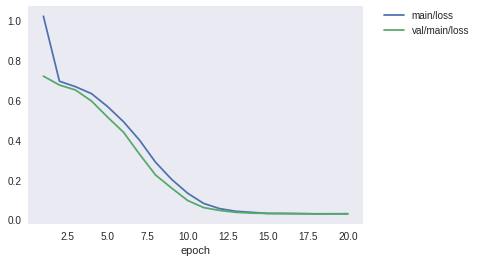

In [0]:
from IPython.display import Image
Image('result/loss.png')

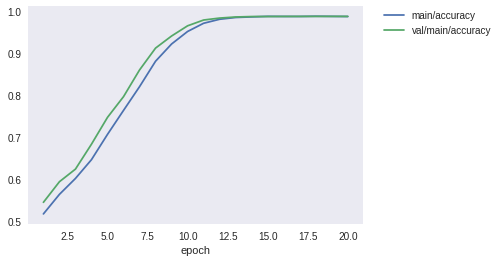

In [0]:
Image('result/accuracy.png')

うまく学習が進んでいるようです．Training loss, Validation lossともにほぼ0近くまで下がっており，また両者のデータセットに対するAccuracyも最大の1に近づいていっています．

これらのプロットは，Trainerの初期化の際に渡す`out`という引数で指定された場所に画像として保存されています．これは逐次更新されているので，実際には学習の途中でもその時点でのプロットを確認することができます．学習の進み具合を視覚的に確認するのに便利です．

[▲ Go to index](#index)

<a id="evaluation"></a>
## 4.5 評価

さて，学習結果は一見良好でした．Accuracyは最大値の1にほぼ漸近していました．しかし，この指標はどういう指標なのでしょうか？何をもって「精度（Accuracy）」と言っていたのでしょうか．

一般的にSemantic Segmentationの結果は上で「accuracy」と表示されていた**Pixel accuracy**や，それとは異なる指標である**Mean Intersection over Union (mIoU)**といった値で評価が行われます．それぞれの定義は以下のようになっています．

正解クラスが$i$であるピクセルをモデルがクラス$j$に分類した数を$N_{ij}$とすると，

$$
{\rm Pixel\ Accuracy} = \frac{\sum_{i=1}^k N_{ii}}{\sum_{i=1}^k \sum_{j=1}^k N_{ij}}
$$

$$
{\rm mIoU} = \frac{1}{k} \sum_{i=1}^k \frac{N_{ii}}{\sum_{j=1}^k N_{ij} + \sum_{j=1}^k N_{ji} - N_{ii}}
$$

です．では，改めてこの2つの値をValidationデータセットに対して，**今学習したモデルを使って計算してみましょう．**

今回は，これらの値を計算するために，[ChainerCV](https://github.com/chainer/chainercv) [[11]](#11)を用います．ChainerCVはコンピュータビジョンタスクで頻出する計算やモデル・データ等の扱いを統一的に行えるChainerの追加パッケージです．上の2つの指標をあらためて計算するために，ChainerCVが提供するSemantic Segmentationタスク用の評価指標計算のための関数を用いてみましょう．

以下のセルを実行してください．

In [0]:
from chainer import cuda
from chainercv import evaluations

def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIou:', evals['miou'])
    
evaluate(trainer, val, device=0)

Pixel Accuracy: 0.9873551588792068
mIou: 0.6885283864600762


2つの数字が表示されました．

Pixel Accuracyの値は`PrintReport`が表示した val/main/accuracy と同じ値になっています．学習中に"accuracy"として表示していたものは，Pixel Accuracyと同じものでした．こちらは，とても高い値を示しています．最大値が1に対して，0.98以上の値が出ます．

一方で，同じ最大値1の指標であるmean IoU（`miou`）が思ったより低いことが分かります．なぜでしょうか．

Pixel Accuracyは画像全体の画素数に対して，true positive + true negative（つまり，黒を黒，白を白と当てられた合計数） の割合を見るため，画像全体に対して negative (
黒）が多い場合は true positive （白を当てられた数）が小さくてもtrue negativeが大きければ結果としてPixel Accuracyは高い値になります．つまり，**class imbalance（白と黒の数が大きく違う）が起きている際に，少ないクラスへの予測誤差が相対的に小さくなる**ということです．

一方，mean IoU の場合は，予測と正解の両画像における「positiveとtrueの和領域」（白と予測した部分と，白が正解である領域の和）に対する「true positive」（白という予測が正解していた領域）の割合を見るので，画像全体の大きさに影響されません．わかりやすく図にすると，以下のようになります．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/miou.png" width="500" />

この図の言葉で書くと，IoUは，

$$IoU = \frac{\rm true\_positive}{{\rm positive} + {\rm true} - {\rm true\_positive}}$$

となります．

では，実際に得られたモデルを使って validation データに予測を行った結果を可視化して，**「Pixel Accuracy は高いが mIoU が低い」ことの問題を確認してみましょう**．以下のセルを実行してください．

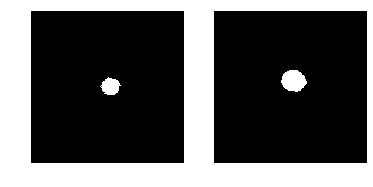

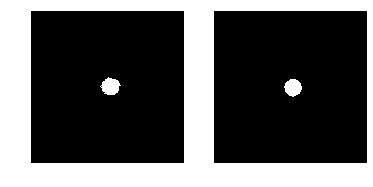

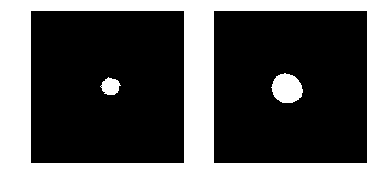

In [0]:
def show_predicts(trainer, val, device=-1, n_sample=3):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)        
        fig, axes = plt.subplots(1, 2)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        axes[1].imshow(label[0], cmap='gray')

        plt.show()

show_predicts(trainer, val, device=0)

左の列が予測ラベルで，右の列が正解ラベルです．3行目に顕著なように，予測のpositive領域（白い領域）はかなり正解に対して小さめに出ています．これでも全体を平均してPixel Accuracy 99%以上ということは，Pixel Accuracyは評価指標として今回のようなデータセットにはあまり合っていない可能性があります．

以降は，どうやって`miou`(mean Intersection over Union)を改善するかに取り組んでみましょう．

[▲ Go to index](#index)

<a id="cnn_segmentation"></a>
# 5. 畳み込みネットワークを用いたセグメンテーション

mIoU改善のため，モデルを全結合層のみから構成されるものから，画像関連のタスクで多く用いられる，畳み込みレイヤを用いたより深いモデルに変えてみましょう．今回用いるLinkは，`Convolution2D`と`Deconvolution2D`の2つだけです．それぞれ，カーネルサイズ（`ksize`），ストライド（`stride`），パディング（`pad`）を指定することができます．これらがどのように出力を変化させるかを，まずはまとめてみましょう．

[▲ Go to index](#index)

<a id="convolution_layer"></a>
## 5.1 Convolutionレイヤ

`Convolution2D`というLinkは，一般的な畳込みレイヤの実装です．畳み込み層のパラメータを設定する際には，以下の点を知っておくと便利です．

- paddingを使って計算後の出力サイズを維持しやすくするために，奇数のカーネルサイズにする（$\lfloor {\rm ksize} / 2 \rfloor$をpadに指定すると，stride=1の際に画像サイズが変わらなくなる）
- 出力feature mapを縮小したい場合は，>1の値をstrideに与える（stride=nだと1/nになる）
- 出力サイズは，$({\rm input\_size} + {\rm pad} \times 2) / {\rm stride} + 1$になる．つまり，strideを大きくすると出力特徴マップは小さくなる．

[▲ Go to index](#index)

<a id="deconvolution_layer"></a>
## 5.2 Deconvolutionレイヤ

`Deconvolution2D`は，その名とは異なり数学的な意味でのdeconvolutionではありません（！）そのため，Transposed convolutionや，Backward convolutionと呼ばれることも多いレイヤです．フィルタの適用の仕方はConvolutionと同じで，ただ事前に入力特徴マップの値を飛び飛びに配置するなどの処理が入る部分が異なっています．`Deconvolution2D`レイヤのパラメータを設定する際には，以下の点を知っておくと便利です．

- カーネルサイズをstrideで割り切れる数にする（checker board artifactを防ぐため．こちらを参考のこと：[Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)）
- 出力サイズは，${\rm stride} \times ({\rm input\_size} - 1) + {\rm ksize} - 2 * {\rm pad}$となるので，目的の拡大後サイズになるようパラメータを調整する

Deconvolution2Dにおいては，padが意味するものが少し直感的でないため，以下に実際に行われる操作を説明した図を用意しました．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/deconv_pad-0.png" width=500 />
<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/deconv_pad-1.png" width=500 />

気をつける点は，ksizeとstrideに従って配置・拡張したfeature mapの周囲を「削る量」がpadになっている点です．そのあと行われる演算自体はstride=1, pad=0のConvolutionと同じになります．

こちらに，非常にわかりやすく各種Convolution/Deconvolutionの計算を表したGIFアニメがあるので，参考にしてください：[Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)

[▲ Go to index](#index)

<a id="fcn"></a>
## 5.3 全畳込みネットワーク

それではさっそくConvolutionレイヤーとDeconvolutionレイヤーのみからなるネットワークをChainerで書いてみましょう！以下のモデルは，Fully Convolutional Networkと呼ばれるネットワークに類似したものです．詳しくはこちらの文献を参照してください [[4](#4), [5](#5), [6](#6)]

以下のFullyConvolutionalNetworkというモデルの定義には，FIXME_1 ~ FIXME_5まで，5つの定数が含まれていますが，値が与えられていません．それぞれは，Convolutionの出力側のチャンネル数になります．試しにこれを，

- FIXME_1 = 64
- FIXME_2 = 128
- FIXME_3 = 128
- FIXME_4 = 128
- FIXME_5 = 128

と書き換えて，下のセルを実行してみましょう．入力チャンネル数は，`None`を与えておくと，実行時に自動的に決定してくれます．

In [0]:
FIXME_1 = 64
FIXME_2 = 128
FIXME_3 = 128
FIXME_4 = 128
FIXME_5 = 128

In [0]:
from chainer import reporter
from chainer import cuda
from chainercv import evaluations

class FullyConvolutionalNetwork(chainer.Chain):
    
    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # と書いても良い！
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, FIXME_5, ksize=1, stride=1, pad=0)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書いても良い！
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=16, pad=8)
        self.out_h = out_h
        self.out_w = out_w
    
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        
        h = F.relu(self.conv3(h)) 
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)
        
        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

print(FullyConvolutionalNetwork(256, 256)(np.zeros((1, 1, 256, 256), dtype=np.float32)).shape[2:])


(256, 256)


FIXME_1 ~ FIXME_5を書き換えた上で上のセルを実行すると，ネットワークの出力サイズが表示されます．今回の入力画像は(256, 256)サイズの画像ですから，出力が256 x 256という同じ大
きさになっていることが確認できればOKです．

[▲ Go to index](#index)

<a id="new_classifier"></a>
## 5.4 Classifierクラスの改良

次に，学習中にチェックするものとして，Pixel AccuracyだけでなくmIOUも追加するために，ロス関数を計算するClassifierクラスを，自分でカスタマイズしたものに置き換えます．それは，以下のように定義されます．下記のセルを実行してみましょう．

In [0]:
class PixelwiseSigmoidClassifier(chainer.Chain):
    
    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor
    
    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)
        
        # 2クラス分類の誤差を計算
        loss = F.sigmoid_cross_entropy(y, t)

        # 予測結果（0~1の連続値を持つグレースケール画像）を二値化し，
        # ChainerCVのeval_semantic_segmentation関数に正解ラベルと
        # 共に渡して各種スコアを計算
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        # 学習中のログに出力
        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

Trainerは，Optimizerにセットされたモデルが「ロスの値を返す」ものと考えるので，最初のモデルではモデルの根幹部分をとってロスを計算して返すような`L.Classifier`でモデルをくるんでOptimizerに渡していました．Chainerが用意しているこの`L.Classifier`は，内部でロスだけでなくAccuracyも計算し，`reporter.report`に辞書を渡す形で`LogReport`などのExtensionが補足できるように値の報告を行うまでやってくれます．1つ目のモデルでは，この`L.Classifier`の引数にモデルだけでなく`lossfun`と`accfun`も指定することで，この`PixelwiseSigmoidClassifier`とほぼおなじような処理を行うようにしていました．しかし，`L.Classifier`はmean IoUの計算をしてくれません．

そこで，今回は`L.Classifier`を自前の`PixelwiseSigmoidClassifier`に置き換え，自分で実際のロスとなる`F.sigmoid_cross_entropy`の計算を書きつつ，予測（上記コード中の`y`）に対してPixel Accuracyとmean IoUの両方を計算して，報告するようにします．`__call__`自体はロスの値（スカラ）を返すことが期待されているので，`F.sigmoid_cross_entropy`の返り値である`loss`だけを`return`しています．

[▲ Go to index](#index)

<a id="new_training"></a>
## 5.5 新しいモデルを使った学習

では，これらのモデルとカスタムClassifierを使って，Trainerによる学習を行ってみましょう．以下のセルを実行してください．

In [0]:
def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=256, out_w=256)    
    train_model = PixelwiseSigmoidClassifier(model)
    
    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)
    
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    
    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')
    
    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer

これが今回用いるTrainerオブジェクトを作成する関数です．最初のケースと違うところは，ログをファイルに記録する`LogReport`や標準出力にログを指定項目を出力する`PrintReport`，またグラフを出力する`PlotReport`拡張で`loss`と`accuracy`（ここでは`pa`=Pixel Accuracy）だけでなく`miou`も出力しているところです．

それでは学習を開始します．最初のモデルではmiouが0.68強までしかいかなかったことを思い出しつつ，経過を見てみましょう．今回はモデルが大きくなりパラメータ数も増えているため，少し学習に時間がかかります（6分強かかります）

下記のセルを実行してください．

In [0]:
%%time
trainer = create_trainer(128, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.210765    0.491811    0.983621    0.20913        0.491082       0.982165     
20          0.0781215   0.492008    0.984015    0.0833074      0.491152       0.982304     
30          0.0473708   0.495664    0.983731    0.0532375      0.496356       0.982411     
40          0.0405379   0.604345    0.986719    0.0456601      0.530503       0.983465     
50          0.0356873   0.654865    0.987756    0.0376054      0.61915        0.986093     
60          0.025901    0.763542    0.991377    0.0279689      0.730481       0.989386     
70          0.023773    0.718306    0.990418    0.0229332      0.756056       0.990774     
80          0.0166831   0.81712     0.993366    0.0185943      0.813726       0.992413     
90          0.0141437   0.860878    0.994674    0.0158306      0.82669        0.993365     
100         0.0111886   0.874023    0.995529    0.0139906      0.843826       0.99

学習が終了しました．`PrintReport`が出力した経過の値を見る限り，mIoUが少なくとも0.90近くまで到達していることがわかります．

[▲ Go to index](#index)

<a id="check_result"></a>
## 5.6 学習結果を見てみよう

では，今回の学習で`PlotReport`拡張が出力したグラフを見てみましょう．下記の3つのセルを実行してください．

Loss


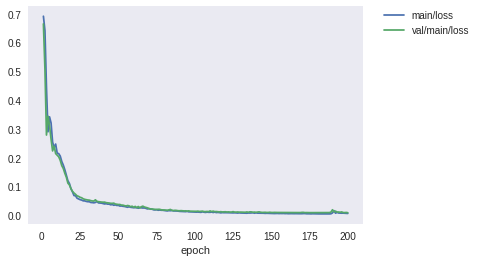

In [0]:
from IPython.display import Image
print('Loss')
Image('result_fcn/loss.png')

mean IoU


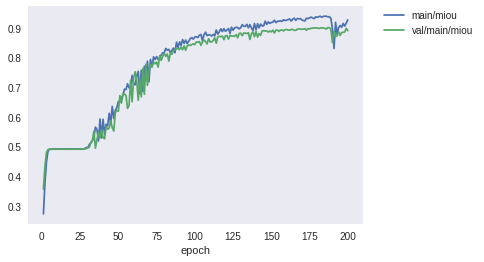

In [0]:
print('mean IoU')
Image('result_fcn/miou.png')

Pixel Accuracy


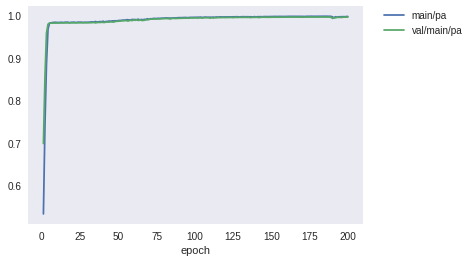

In [0]:
print('Pixel Accuracy')
Image('result_fcn/pa.png')

Pixel Accuracyが0.99以上であるだけでなく，mIoUも0.90近くまで上がっています．mIoUに注目すると，最初のモデル（0.68程度）と比べて随分精度が上がっていることがわかると思います．実際にvalidationデータに対して推論を行った際の予測ラベル画像を見て，結果を確認しましょう．以下のセルを実行してください．

Pixel Accuracy: 0.9960227379432092
mIou: 0.8903594309796115


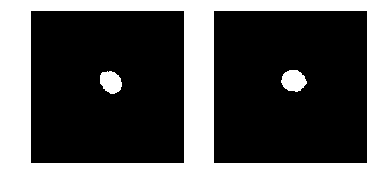

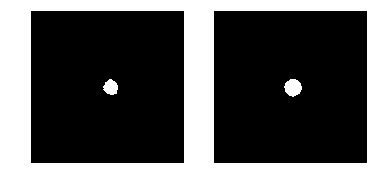

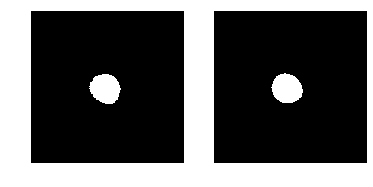

In [0]:
evaluate(trainer, val, device=0)
show_predicts(trainer, val, device=0, )

一つ目のモデルの結果を確認した際と同じ画像が3つ並べられています．一つ目の結果よりも，特に3行目に注目すると，だいぶ正解ラベルに近い形のマスクを推定できていることがわかります．

畳み込み層だけからなるより深いモデルを学習に用いることで，大きく結果を改善することができました．しかし，もう改善の余地が無いというわけではありません．さらに結果を改善するにはどうすればよいのでしょうか？

[▲ Go to index](#index)

<a id="go_further"></a>
## 6. さらなる精度向上へのヒント

Semantic Segmentationでは，どうやって入力画像における広い範囲の情報を1つのピクセルの予測に役立てるか，どうやって複数の解像度における予測結果を考慮するか，などが重要な問題意識となります．また，ニューラルネットワークでは一般に，レイヤを重ねれば重ねるほど，特徴量の抽象度が上がっていくとされています．しかし，Semantic Segmentationでは，正確に対象物体の輪郭を表すマスク画像を出力したいので，low levelな情報（エッジ・局所的な画素値勾配のような情報，色の一貫性など）も考慮して最終的な予測結果を作りたくなります．そのために，ネットワークの出力に近いレイヤでどうやって入力に近いレイヤで取り出された特徴を活用すればよいか，が重要になってきます．

これらの視点からいくつもの新しいモデルが提案されています．代表的なものを挙げると，例えば以下のようなものがあります．

<a id="SegNet"></a>
### 6.1 SegNet [[8]](#8)

下層で行ったMax Poolingの際に「どのピクセルが最大値だったか（pooling indices)
」の情報をとっておき，上層でそのpooling indicesを使ってUpsamplingする手法．[ChainerCV](https://github.com/chainer/chainercv)にてChainerで実装されたモデル及び完全な再現実験を含むコードが公開されている．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/SegNet.png" width="500" />

<a id="U-Net"></a>
### 6.2 U-Net [[9]](#9)

下層の出力特徴マップを，上層の入力にConcatenateすることで活用する構造．全体がアルファベットの "U" のような形をしていることから「U-Net」と呼ばれる

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/U-Net.png" width="500" />

<a id="PSPNet"></a>
### 6.3 PSPNet [[10]](#10)

Pyramid Pooling Moduleを提案し，異なる大きさのsub-regionごとの特徴を大域的なコンテキストを考慮するために活用することで，ImageNet 2017 Scene Parsing Challengeで優勝したモデル．

<img src="https://github.com/mitmul/chainer-handson/raw/master/segmentation-handson/PSPNet.png" width="500" />

それでは，お時間のある方は，こういった論文を参考に，上記二つ目のモデルを改良して，さらに高い精度が出せるよう工夫してみてください．

[▲ Go to index](#index)

<a id="information"></a>
# 7. その他の参考資料

最後に，本資料作成者によるいくつかのセグメンテーションに関する資料をここに載せます．

- [最近のセグメンテーション手法の簡単な紹介](https://www.slideshare.net/mitmul/a-brief-introduction-to-recent-segmentation-methods)
- [Pyramid Scene Parsing Network (CVPR 2017)の紹介](https://www.slideshare.net/mitmul/unofficial-pyramid-scene-parsing-network-cvpr-2017)

また，以下のレビュー論文も昨今のDeep learningを活用したセグメンテーション手法についてよくまとまっており，参考になります．

- [A Review on Deep Learning Techniques Applied to Semantic Segmentation](https://arxiv.org/abs/1704.06857)

[▲ Go to index](#index)

<a id="References"></a>
# References

<a id="1"></a>
[1] Sunnybrook cardiac images from earlier competition http://smial.sri.utoronto.ca/LV_Challenge/Data.html

<a id="2"></a>
[2] This "Sunnybrook Cardiac MR Database" is made available under the CC0 1.0 Universal license described above, and with more detail here: http://creativecommons.org/publicdomain/zero/1.0/

<a id="3"></a>
[3] Attribution:
Radau P, Lu Y, Connelly K, Paul G, Dick AJ, Wright GA. "Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI." The MIDAS Journal -Cardiac MR Left Ventricle Segmentation Challenge, http://hdl.handle.net/10380/3070

<a id="4"></a>
[4] http://fcn.berkeleyvision.org/

<a id="5"></a>
[5] Long, Shelhamer, Darrell; "Fully Convoutional Networks for Semantic Segmentation", CVPR 2015.

<a id="6"></a>
[6] Zeiler, Krishnan, Taylor, Fergus; "Deconvolutional Networks", CVPR 2010.

<a id="7"></a>
[7] https://www.kaggle.com/c/second-annual-data-science-bowl/details/deep-learning-tutorial

<a id="8"></a>
[8] Vijay Badrinarayanan, Alex Kendall and Roberto Cipolla "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation." PAMI, 2017

<a id="9"></a>
[9] Olaf Ronneberger, Philipp Fischer, Thomas Brox, "U-Net: Convolutional Networks for Biomedical Image Segmentation", MICCAI 2015

<a id="10"></a>
[10] Hengshuang Zhao, Jianping Shi, Xiaojuan Qi, Xiaogang Wang and Jiaya Jia, "Pyramid Scene Parsing Network", CVPR 2017

<a id="11"></a>
[11] Yusuke Niitani, Toru Ogawa, Shunta Saito, Masaki Saito, "ChainerCV: a Library for Deep Learning in Computer Vision", ACM Multimedia (ACMMM), Open Source Software Competition, 2017

(c) Shunta Saito, Preferred Networks, inc. 2017